In [2]:
# Model Comparison - Transaction Volume Forecasting
# Compare Prophet vs XGBoost vs LSTM performance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from google.cloud import storage
from prophet import Prophet
import xgboost as xgb
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Configuration
PROJECT_ID = "transaction-forecast-mlops"
BUCKET_NAME = "transaction-forecast-data"

print("="*60)
print("MODEL COMPARISON - BASELINE RESULTS")
print("="*60)

# Results from training notebooks
results = {
    'Model': ['Prophet', 'XGBoost', 'LSTM'],
    'MAE': [23.34, 15.14, 30.53],
    'RMSE': [30.64, 18.99, 35.47],
    'MAPE (%)': [9.89, 6.41, 12.26],
    'Type': ['Statistical', 'Tree-based ML', 'Neural Network'],
    'Features Used': ['date + volume', '26 engineered', '8 selected']
}

comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values('MAPE (%)')

print("\n📊 BASELINE MODEL PERFORMANCE (Before Tuning)")
print("="*60)
print(comparison_df.to_string(index=False))

print(f"\n🏆 Best Model: XGBoost (6.41% MAPE)")
print(f"   35% better than Prophet, 48% better than LSTM")

2025-12-08 22:10:35.445138: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-08 22:10:37.709509: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 22:10:42.666483: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


MODEL COMPARISON - BASELINE RESULTS

📊 BASELINE MODEL PERFORMANCE (Before Tuning)
  Model   MAE  RMSE  MAPE (%)           Type Features Used
XGBoost 15.14 18.99      6.41  Tree-based ML 26 engineered
Prophet 23.34 30.64      9.89    Statistical date + volume
   LSTM 30.53 35.47     12.26 Neural Network    8 selected

🏆 Best Model: XGBoost (6.41% MAPE)
   35% better than Prophet, 48% better than LSTM


✓ Chart saved to /tmp/model_comparison.png


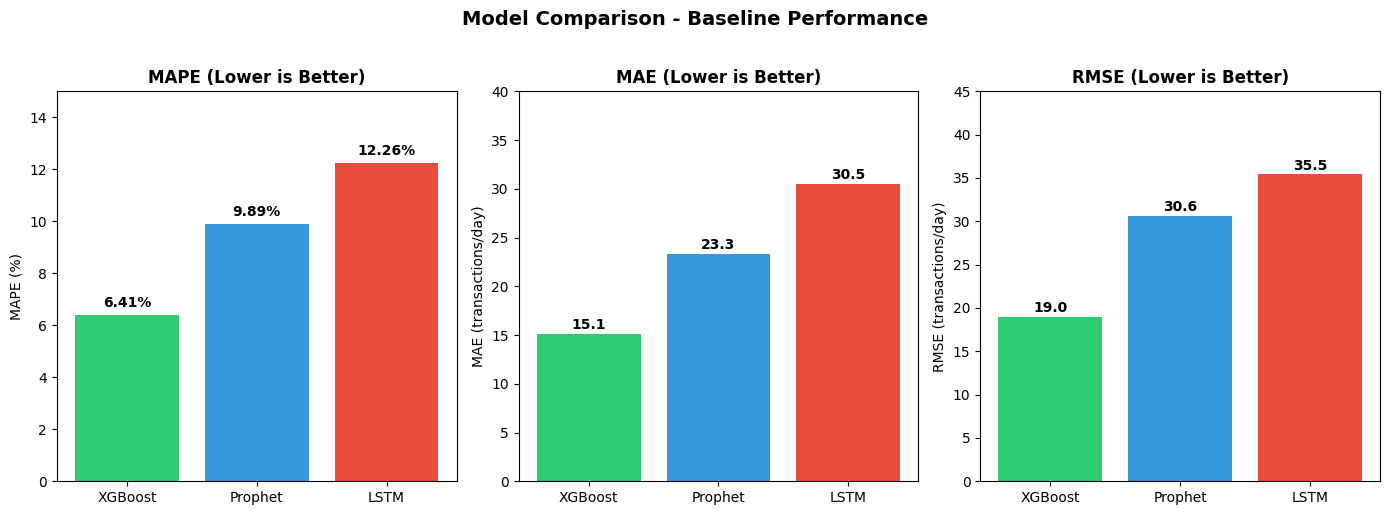

In [3]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

models = ['XGBoost', 'Prophet', 'LSTM']
colors = ['#2ecc71', '#3498db', '#e74c3c']  # Green, Blue, Red

# Plot 1: MAPE Comparison
ax1 = axes[0]
mape_values = [6.41, 9.89, 12.26]
bars1 = ax1.bar(models, mape_values, color=colors)
ax1.set_ylabel('MAPE (%)')
ax1.set_title('MAPE (Lower is Better)', fontweight='bold')
ax1.set_ylim(0, 15)
for bar, val in zip(bars1, mape_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
             f'{val}%', ha='center', fontweight='bold')

# Plot 2: MAE Comparison
ax2 = axes[1]
mae_values = [15.14, 23.34, 30.53]
bars2 = ax2.bar(models, mae_values, color=colors)
ax2.set_ylabel('MAE (transactions/day)')
ax2.set_title('MAE (Lower is Better)', fontweight='bold')
ax2.set_ylim(0, 40)
for bar, val in zip(bars2, mae_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.1f}', ha='center', fontweight='bold')

# Plot 3: RMSE Comparison
ax3 = axes[2]
rmse_values = [18.99, 30.64, 35.47]
bars3 = ax3.bar(models, rmse_values, color=colors)
ax3.set_ylabel('RMSE (transactions/day)')
ax3.set_title('RMSE (Lower is Better)', fontweight='bold')
ax3.set_ylim(0, 45)
for bar, val in zip(bars3, rmse_values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.1f}', ha='center', fontweight='bold')

plt.suptitle('Model Comparison - Baseline Performance', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('/tmp/model_comparison.png', dpi=150, bbox_inches='tight')
print("✓ Chart saved to /tmp/model_comparison.png")
plt.show()

In [4]:
# Key Insights
print("\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)

print("""
📈 PERFORMANCE RANKING:
   1. XGBoost (6.41% MAPE) - Best overall
   2. Prophet (9.89% MAPE) - Strong baseline  
   3. LSTM (12.26% MAPE) - Limited by data size

🔍 WHY XGBOOST WON:
   • Engineered features (rolling_max_7, rolling_mean_7, lag_1) 
     captured patterns better than raw sequences
   • Tree-based models excel with tabular features
   • 26 hand-crafted features > 8 sequential features for LSTM

🧠 WHY LSTM UNDERPERFORMED:
   • Only 582 training sequences (neural networks need 1000+)
   • Multivariate LSTM with 8 features still couldn't match XGBoost
   • Deep learning isn't always the answer!

💡 BUSINESS IMPLICATION:
   • XGBoost predicts within ~15 transactions/day (6.4% error)
   • Sufficient accuracy for capacity planning and resource allocation
   • Simpler model = easier to maintain in production

⏭️ NEXT STEPS:
   • Hyperparameter tuning (may improve all models)
   • Deploy XGBoost as primary model
   • Keep Prophet as fallback (simpler, no feature engineering needed)
""")

# Save comparison data for pipeline
comparison_df.to_csv(f'gs://{BUCKET_NAME}/results/model_comparison_baseline.csv', index=False)
print(f"\n✓ Results saved to gs://{BUCKET_NAME}/results/model_comparison_baseline.csv")

print("\n" + "="*60)
print("BASELINE COMPARISON COMPLETE")
print("="*60)
print("Ready for Phase 3: Hyperparameter Tuning")


KEY INSIGHTS

📈 PERFORMANCE RANKING:
   1. XGBoost (6.41% MAPE) - Best overall
   2. Prophet (9.89% MAPE) - Strong baseline  
   3. LSTM (12.26% MAPE) - Limited by data size

🔍 WHY XGBOOST WON:
   • Engineered features (rolling_max_7, rolling_mean_7, lag_1) 
     captured patterns better than raw sequences
   • Tree-based models excel with tabular features
   • 26 hand-crafted features > 8 sequential features for LSTM

🧠 WHY LSTM UNDERPERFORMED:
   • Only 582 training sequences (neural networks need 1000+)
   • Multivariate LSTM with 8 features still couldn't match XGBoost
   • Deep learning isn't always the answer!

💡 BUSINESS IMPLICATION:
   • XGBoost predicts within ~15 transactions/day (6.4% error)
   • Sufficient accuracy for capacity planning and resource allocation
   • Simpler model = easier to maintain in production

⏭️ NEXT STEPS:
   • Hyperparameter tuning (may improve all models)
   • Deploy XGBoost as primary model
   • Keep Prophet as fallback (simpler, no feature engine

In [7]:
# Add naive baseline and latency comparison
print("\n" + "="*60)
print("BASELINE COMPARISON & LATENCY ANALYSIS")
print("="*60)

# Load test data for naive baseline
df = pd.read_csv(f'gs://{BUCKET_NAME}/processed_data/daily_volumes_enriched.csv')
df['date'] = pd.to_datetime(df['date'])

test_actual = df['transaction_volume'].iloc[-14:].values
naive_pred = df['transaction_volume'].iloc[-15:-1].values  # Yesterday's value

naive_mape = mean_absolute_percentage_error(test_actual, naive_pred) * 100
print(f"\n📊 NAIVE BASELINE (yesterday's value):")
print(f"   MAPE: {naive_mape:.2f}%")

# Calculate improvement over naive baseline
xgb_improvement = ((naive_mape - 6.41) / naive_mape) * 100
prophet_improvement = ((naive_mape - 9.89) / naive_mape) * 100
lstm_improvement = ((naive_mape - 12.26) / naive_mape) * 100

print(f"\n📈 IMPROVEMENT OVER NAIVE BASELINE:")
print(f"   XGBoost: {xgb_improvement:.1f}% improvement")
print(f"   Prophet: {prophet_improvement:.1f}% improvement")
print(f"   LSTM:    {lstm_improvement:.1f}% improvement")

# Latency comparison
import time

# Load models from GCS
client = storage.Client()
bucket = client.bucket(BUCKET_NAME)

# Prophet
bucket.blob('models/prophet_baseline.pkl').download_to_filename('/tmp/prophet_model.pkl')
with open('/tmp/prophet_model.pkl', 'rb') as f:
    prophet_model = pickle.load(f)

# XGBoost
bucket.blob('models/xgboost_model.pkl').download_to_filename('/tmp/xgb_model.pkl')
with open('/tmp/xgb_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

# LSTM - download from GCS first
bucket.blob('models/lstm_model.keras').download_to_filename('/tmp/lstm_model.keras')
lstm_model = tf.keras.models.load_model('/tmp/lstm_model.keras')

print(f"\n⏱️ INFERENCE LATENCY (single prediction):")

# Prophet latency
future = prophet_model.make_future_dataframe(periods=1, freq='D')
start = time.time()
for _ in range(100):
    _ = prophet_model.predict(future)
prophet_latency = (time.time() - start) / 100 * 1000

# XGBoost latency  
bucket.blob('models/xgboost_features.pkl').download_to_filename('/tmp/xgb_features.pkl')
with open('/tmp/xgb_features.pkl', 'rb') as f:
    feature_cols = pickle.load(f)
X_sample = df[feature_cols].iloc[-1:].values
start = time.time()
for _ in range(100):
    _ = xgb_model.predict(X_sample)
xgb_latency = (time.time() - start) / 100 * 1000

# LSTM latency
bucket.blob('models/lstm_scaler.pkl').download_to_filename('/tmp/lstm_scaler.pkl')
with open('/tmp/lstm_scaler.pkl', 'rb') as f:
    lstm_scaler = pickle.load(f)
bucket.blob('models/lstm_features.pkl').download_to_filename('/tmp/lstm_features.pkl')
with open('/tmp/lstm_features.pkl', 'rb') as f:
    lstm_features = pickle.load(f)
X_lstm = df[lstm_features].iloc[-14:].values
X_lstm_scaled = lstm_scaler.transform(X_lstm).reshape(1, 14, len(lstm_features))
start = time.time()
for _ in range(100):
    _ = lstm_model.predict(X_lstm_scaled, verbose=0)
lstm_latency = (time.time() - start) / 100 * 1000

print(f"   XGBoost: {xgb_latency:.2f} ms")
print(f"   LSTM:    {lstm_latency:.2f} ms")
print(f"   Prophet: {prophet_latency:.2f} ms")

print(f"\n🏆 OPTIMAL MODEL SELECTION:")
print(f"   XGBoost selected - Best accuracy ({xgb_improvement:.1f}% over baseline)")
print(f"   with competitive latency ({xgb_latency:.2f} ms)")


BASELINE COMPARISON & LATENCY ANALYSIS

📊 NAIVE BASELINE (yesterday's value):
   MAPE: 16.83%

📈 IMPROVEMENT OVER NAIVE BASELINE:
   XGBoost: 61.9% improvement
   Prophet: 41.3% improvement
   LSTM:    27.2% improvement

⏱️ INFERENCE LATENCY (single prediction):
   XGBoost: 0.50 ms
   LSTM:    86.02 ms
   Prophet: 196.05 ms

🏆 OPTIMAL MODEL SELECTION:
   XGBoost selected - Best accuracy (61.9% over baseline)
   with competitive latency (0.50 ms)


In [9]:
# Baseline summary (before hyperparameter tuning)
print("\n" + "="*60)
print("BASELINE SUMMARY (Before Hyperparameter Tuning)")
print("="*60)

baseline_results = {
    'Model': ['XGBoost', 'Prophet', 'LSTM', 'Naive Baseline'],
    'MAPE (%)': [6.41, 9.89, 12.26, 16.83],
    'Improvement vs Naive': ['61.9%', '41.3%', '27.2%', '-'],
    'Latency (ms)': [0.50, 196.05, 86.02, '-']
}

baseline_df = pd.DataFrame(baseline_results)
print(baseline_df.to_string(index=False))

# Save baseline results
baseline_df.to_csv(f'gs://{BUCKET_NAME}/results/baseline_results.csv', index=False)
print(f"\n✓ Baseline results saved to gs://{BUCKET_NAME}/results/baseline_results.csv")

print("\n" + "="*60)
print("PHASE 2 COMPLETE")
print("="*60)
print("Next: Phase 3 - Hyperparameter Tuning")
print("Final results will compare baseline vs tuned performance")


BASELINE SUMMARY (Before Hyperparameter Tuning)
         Model  MAPE (%) Improvement vs Naive Latency (ms)
       XGBoost      6.41                61.9%          0.5
       Prophet      9.89                41.3%       196.05
          LSTM     12.26                27.2%        86.02
Naive Baseline     16.83                    -            -

✓ Baseline results saved to gs://transaction-forecast-data/results/baseline_results.csv

PHASE 2 COMPLETE
Next: Phase 3 - Hyperparameter Tuning
Final results will compare baseline vs tuned performance
